# Libraries and Data

In [ ]:
# Mount Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Path to the folder
%cd /content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/Exponential Smoothing and Holt Winters

/content/drive/MyDrive/Python - Time Series Forecasting/Time Series Analysis/Exponential Smoothing and Holt Winters


In [ ]:
# Libraries
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

In [ ]:
# Loading the Data of weekly customer complaints
# and set the date as the index
df = pd.read_csv("weekly_customer_complaints.csv", index_col = "week", parse_dates = True)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,"1,750",37.26%,1,0,0
2018-01-08,"1,701",35.38%,0,0,0
2018-01-15,"1,711",36.22%,1,0,0
2018-01-22,"1,443",38.33%,1,0,0
2018-01-29,"1,397",36.34%,0,0,0


In [ ]:
# Display information about the DataFrame, including data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 261 entries, 2018-01-01 to 2022-12-26
Data columns (total 5 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   complaints               261 non-null    object
 1   discount_rate            261 non-null    object
 2   small_commercial_event   261 non-null    int64 
 3   medium_commercial_event  261 non-null    int64 
 4   big_commercial_event     261 non-null    int64 
dtypes: int64(3), object(2)
memory usage: 12.2+ KB


# Data Pre-processing

In [ ]:
# Remove comma from column 'complaints' and transform the values into float
df['complaints'] = df['complaints'].str.replace(',', '').astype(float)
df.head()

,complaints,discount_rate,small_commercial_event,medium_commercial_event,big_commercial_event
week,,,,,
2018-01-01,1750.0,37.26%,1,0,0
2018-01-08,1701.0,35.38%,0,0,0
2018-01-15,1711.0,36.22%,1,0,0
2018-01-22,1443.0,38.33%,1,0,0
2018-01-29,1397.0,36.34%,0,0,0


In [ ]:
# df.asfreq("W-Mon") - convert the time series data to a specified frequency, in this case, weekly data with Monday as the anchor day.
# Setting freq to W implies that the week starts on a Sunday
df = df.asfreq("W-Mon")
df.index

DatetimeIndex(['2018-01-01', '2018-01-08', '2018-01-15', '2018-01-22',
               '2018-01-29', '2018-02-05', '2018-02-12', '2018-02-19',
               '2018-02-26', '2018-03-05',
               ...
               '2022-10-24', '2022-10-31', '2022-11-07', '2022-11-14',
               '2022-11-21', '2022-11-28', '2022-12-05', '2022-12-12',
               '2022-12-19', '2022-12-26'],
              dtype='datetime64[ns]', name='week', length=261, freq='W-MON')

A list of commonly used frequency aliases:

Time-based frequencies:

- 'D': Calendar day frequency
- 'B': Business day frequency
- 'W': Weekly frequency
- 'W-MON', 'W-TUE', ..., 'W-SUN': Weekly frequency (anchored on a specific day)
- 'M': Month end frequency
- 'MS': Month start frequency
- 'Q': Quarter end frequency
- 'QS': Quarter start frequency
- 'A' or 'Y': Year end frequency
- 'BA' or 'BY': Business year end frequency
- 'AS' or 'YS': Year start frequency
- 'BAS' or 'BYS': Business year start frequency


Hourly, minutely, and secondly frequencies:

- 'H': Hourly frequency
- 'T' or 'min': Minutely frequency
- 'S': Secondly frequency


You can also use multiples, like:

- '2D': Every 2 days
- '4H': Every 4 hours
- '15T' or '15min': Every 15 minutes

# Exploratory Data Analysis

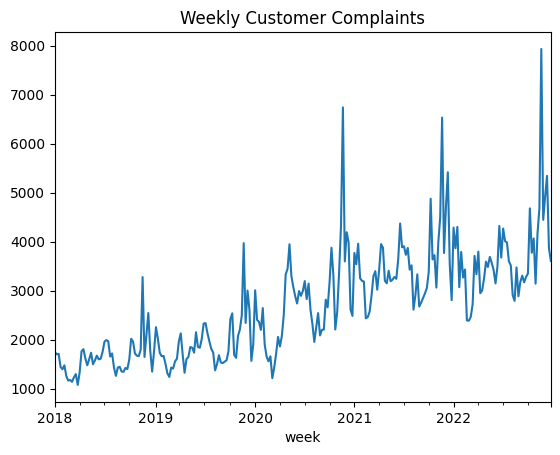

In [ ]:
# Plot the weekly complaint values
df['complaints'].plot(title = 'Weekly Customer Complaints')
plt.show()

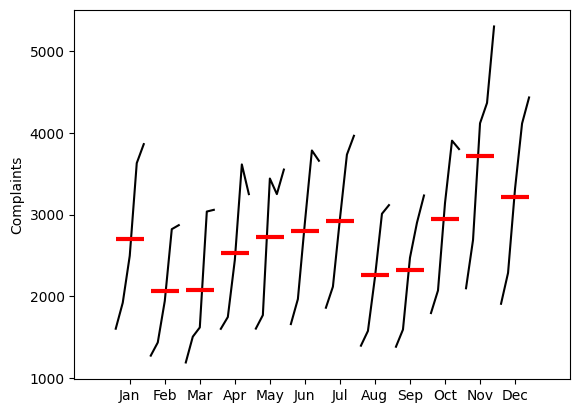

In [ ]:
# month_plot() - To visualize the average value for each month across multiple years in a time series
# red lines - Represents the mean value for each month

# Plotting the monthly seasonality of the complaint values
month_plot(df['complaints'].resample('M').mean(),
           ylabel = 'Complaints')
plt.show()

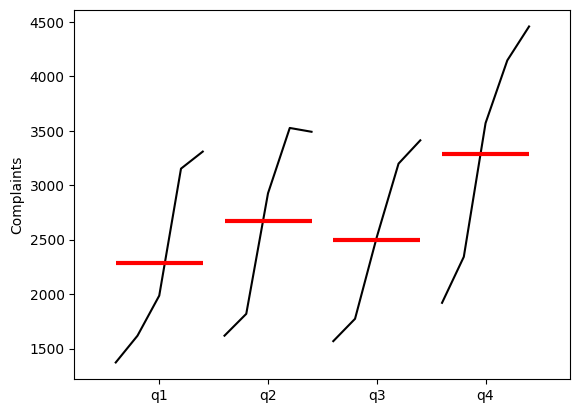

In [ ]:
# quarter_plot() - To visualize seasonal patterns at a quarterly level.
# Q1 (january, february, march), Q2 (april, may, june), Q3 (july, august, september), Q4 (october, november, december)

# Plotting the quarterly seasonality of the complaint values
quarter_plot(df['complaints'].resample('Q').mean(),
           ylabel = 'Complaints')
plt.show()

`seasonal_decompose` - To decompose a time series into its constituent parts to better understand the underlying patterns.

components

- Trend: The overall direction of the series (increasing, decreasing, or stable).
- Seasonal: Repeating patterns at fixed intervals (e.g., daily, weekly, monthly).
- Residual: The remaining variation after removing trend and seasonal components.

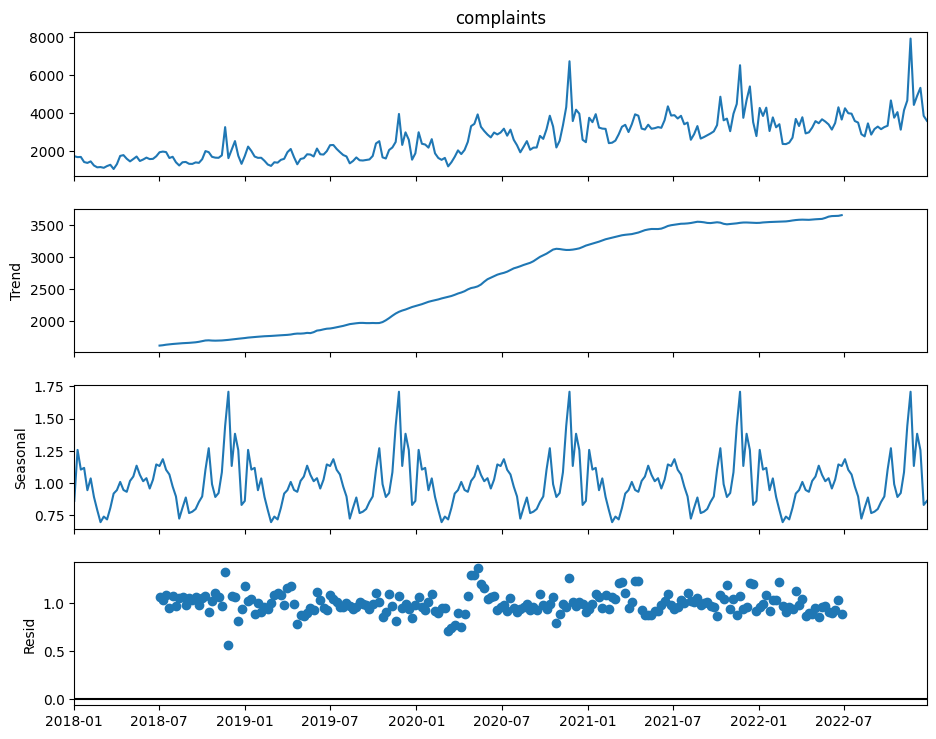

In [ ]:
# Seasonal Decomposition Plots for complaint values
# Multiplicative model type, with yearly seasonality (52 weeks)
decomposition = seasonal_decompose(df['complaints'],
                                   model = 'mul',
                                   period = 52)
fig = decomposition.plot()
fig.set_size_inches(10,8)
plt.show()

Autocorrelation measures the correlation between a time series and a lagged version of itself.

Purpose: To identify patterns or repeating cycles in a time series dataset.

Interpretation:
- Values range from -1 to 1.
- 1 indicates perfect positive correlation.
- -1 indicates perfect negative correlation.
- 0 indicates no correlation.

ACF Plot:
- X-axis: Lag periods
- Y-axis: Correlation coefficient

Key Features:
- At lag 0, autocorrelation is always 1 (a series is perfectly correlated with itself).
- Significant spikes at certain lags indicate repeating patterns.


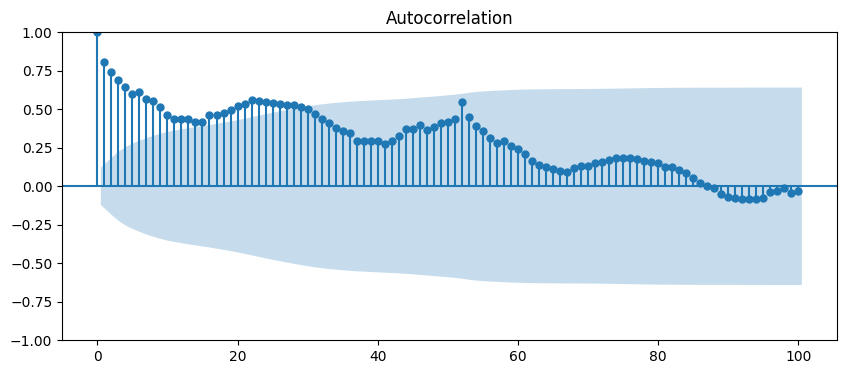

In [ ]:
# Plot the autocorrelation (ACF) of complaint values
fig, ax = plt.subplots(figsize = (10,4))
plot_acf(df['complaints'], lags = 100, ax = ax)
plt.show()

PACF measures the correlation between a time series and its lag, after removing the effects of all shorter lags.

Purpose: To identify the direct relationship between an observation and its lag, without intermediate effects.

Main Difference between ACF and PACF:
- ACF: Measures overall correlation at each lag, including indirect effects.
- PACF: Measures direct correlation at each lag, excluding indirect effects.

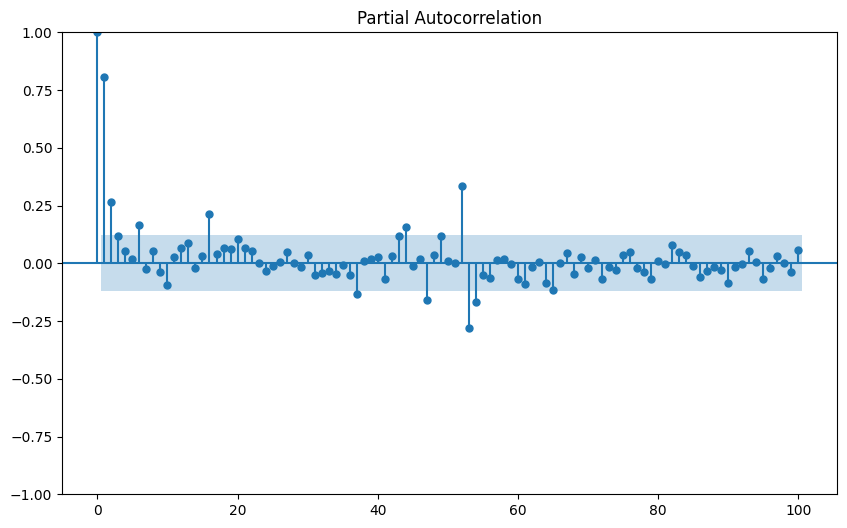

In [ ]:
# Plot the partial autocorrelation (PACF) of complaint values
fig, ax = plt.subplots(figsize = (10,6))
plot_pacf(df['complaints'], lags = 100, ax = ax)
plt.show()

# Training and test

# Goal : to predict the next quarter (13 weeks)

In [ ]:
# Training and Test Split
# Train: all data except last n periods of the column 'complaints'
# Test: last n periods of the column 'complaints'

periods = 13
train, test = df.iloc[:-periods,0], df.iloc[-periods:, 0 ]
test.head()

week
2022-10-03    3350.0
2022-10-10    4679.0
2022-10-17    3773.0
2022-10-24    4065.0
2022-10-31    3142.0
Freq: W-MON, Name: complaints, dtype: float64

# Simple Exponential Smoothing

Simple Exponential Smoothing assigns exponentially decreasing weights to past observations, giving more influence to recent data.

It is especially useful when there is no clear trend or seasonal pattern.

In [ ]:
# Create a Simple Exponential Smoothing model using the training data.
model_simple = SimpleExpSmoothing(train).fit()

# Use the fitted model to forecast future values.
# The forecast is made for the same length as the 'test' data set.
predictions_simple = model_simple.forecast(len(test))

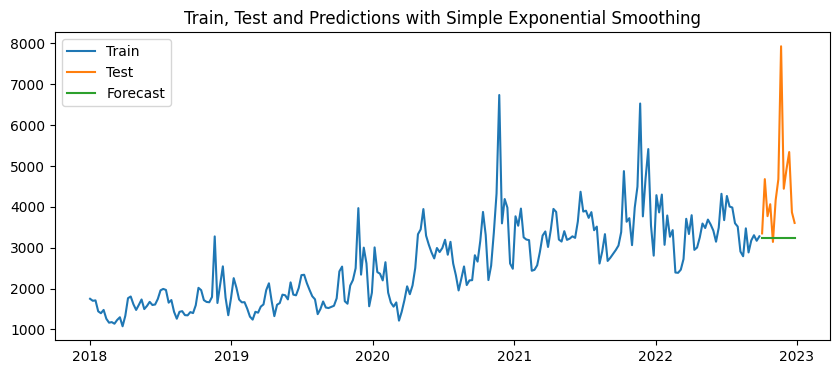

In [ ]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot the train, test, and forecast data
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_simple, label = "Forecast")

# add title and legend to the plot
plt.title("Train, Test and Predictions with Simple Exponential Smoothing")
plt.legend()
plt.show()

# Double Exponential Smoothing

Double Exponential Smoothing (DES), also known as Holt’s Linear Trend Model, is used when the time series data exhibits a trend.

Unlike Simple Exponential Smoothing, which is suitable for data without trends or seasonality, DES can account for both the level and the trend in the data

Key Features:
- Trend Handling -  making it suitable for time series data that show a consistent upward or downward trend over time.
- Components - DES involves two components: the level (smoothed value) and the trend.

In [ ]:
# Double Exponential Smoothing Model
# Initialize and fit an Exponential Smoothing model to the training data
# Use a multiplicative trend component ('mul') and no seasonal component (seasonal=None)

model_double = ExponentialSmoothing(train,
                                    trend = 'mul',
                                    seasonal = None).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
# Use the fitted Double Exponential Smoothing model to forecast future values.
# The forecast is made for the same length as the 'test' data set.
predictions_double = model_double.forecast(len(test))
predictions_double

2022-10-03    3257.344635
2022-10-10    3268.523454
2022-10-17    3279.740638
2022-10-24    3290.996318
2022-10-31    3302.290626
2022-11-07    3313.623695
2022-11-14    3324.995657
2022-11-21    3336.406647
2022-11-28    3347.856798
2022-12-05    3359.346245
2022-12-12    3370.875122
2022-12-19    3382.443564
2022-12-26    3394.051708
Freq: W-MON, dtype: float64

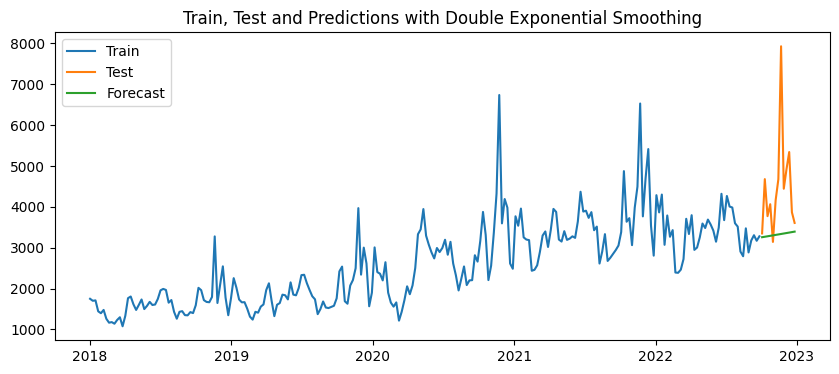

In [ ]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot train, test, and forecasts values
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_double, label = "Forecast")

# add title and legend to the plot
plt.title("Train, Test and Predictions with Double Exponential Smoothing")
plt.legend()
plt.show()

# Triple Exponential Smoothing (Holt-Winters method)

Triple Exponential Smoothing, also known as Holt-Winters Exponential Smoothing, extends Double Exponential Smoothing by adding a seasonal component to handle data with seasonal patterns in addition to trends.

Key Features:
- Seasonality Handling - Triple Exponential Smoothing accommodates time series data with seasonal patterns, which can be daily, weekly, monthly, quarterly, or annual.
- Components - It involves three components: level (smoothed value), trend, and seasonal.

In [ ]:
# Triple Exponential Smoothing Model
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the training data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 52 (weekly data with yearly seasonality)

model_triple = ExponentialSmoothing(train,
                                    trend = 'add',
                                    seasonal = "mul",
                                    seasonal_periods = 52).fit()

In [ ]:
# Use the fitted Triple Exponential Smoothing model to forecast future values.
# The forecast is made for the same length as the 'test' data set.
predictions_triple = model_triple.forecast(len(test))
predictions_triple

2022-10-03    4025.154649
2022-10-10    5034.028978
2022-10-17    3914.089402
2022-10-24    3521.043538
2022-10-31    3417.610126
2022-11-07    4227.903516
2022-11-14    5320.009642
2022-11-21    7238.358344
2022-11-28    4315.881938
2022-12-05    5270.594720
2022-12-12    5256.203861
2022-12-19    3416.859773
2022-12-26    3253.257749
Freq: W-MON, dtype: float64

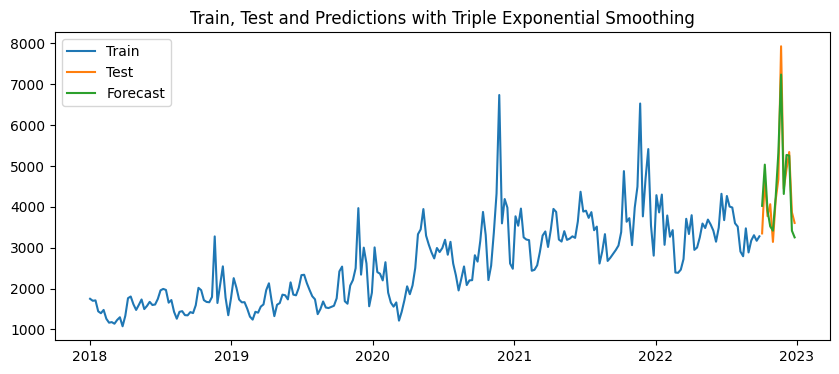

In [ ]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot train, test, and forecasts values
plt.plot(train, label = 'Train')
plt.plot(test, label = 'Test')
plt.plot(predictions_triple, label = "Forecast")

# add title and legend to the plot
plt.title("Train, Test and Predictions with Triple Exponential Smoothing")
plt.legend()
plt.show()

- `MAE` - the average of the absolute differences between predicted and actual values.
- `RMSE` - the square root of the average of squared differences between prediction and actual observation.
It gives a relatively high weight to large errors, making it sensitive to outliers.
- `MAPE` - the size of the error in percentage terms. the average of the absolute percent errors of forecasts, which helps to understand the accuracy in terms of percentage.

In [ ]:
# Calculating the MAE, RMSE, and MAPE
# between the test values and our prediction values
mae = mean_absolute_error(test, predictions_triple)
rmse = mean_squared_error(test, predictions_triple, squared = False)
mape = mean_absolute_percentage_error(test, predictions_triple)

print(f"The MAE is {mae:.2f}")
print(f"The RMSE is {rmse:.2f}")
print(f"The MAPE is {100 * mape:.2f} %")

The MAE is 366.14
The RMSE is 424.83
The MAPE is 8.52 %


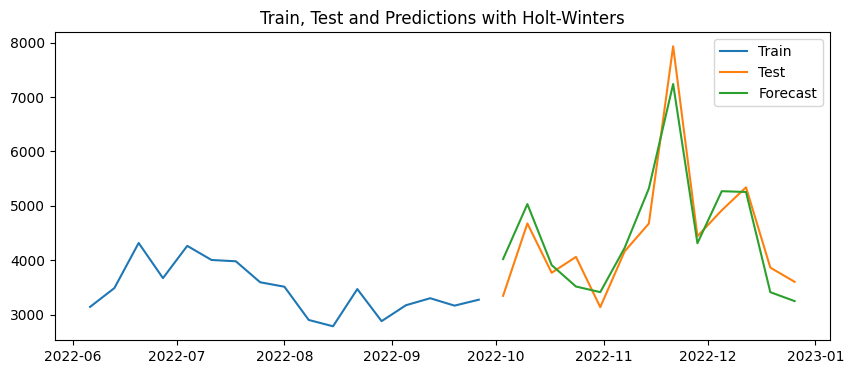

The MAE is 366.14
The RMSE is 424.83
The MAPE is 8.52 %


In [ ]:
# Function to assess model and visualize output
def model_assessment(train, test, predictions, chart_title):
  # Plot training, test, and forecasts
  plt.figure(figsize = (10,4))
  plt.plot(train, label = 'Train')
  plt.plot(test, label = 'Test')
  plt.plot(predictions, label = "Forecast")
  plt.title(f"Train, Test and Predictions with {chart_title}")
  plt.legend()
  plt.show()

  # Calculating the MAE, RMSE, and MAPE
  mae = mean_absolute_error(test, predictions)
  rmse = mean_squared_error(test, predictions, squared = False)
  mape = mean_absolute_percentage_error(test, predictions)

  # Print the calculated error metrics
  print(f"The MAE is {mae:.2f}")
  print(f"The RMSE is {rmse:.2f}")
  print(f"The MAPE is {100 * mape:.2f} %")

# Call the model_assessment function with the specified arguments
model_assessment(train['2022-06':], test, predictions_triple, "Holt-Winters")

# Predicting the future

In [ ]:
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the whole data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 52 (weekly data with yearly seasonality)
model = ExponentialSmoothing(df.complaints,
                             trend = 'add',
                             seasonal = "mul",
                             seasonal_periods = 52).fit()

In [ ]:
 # Predict the values for the next 13 weeks
forecast = model.forecast(13)
forecast

2023-01-02    4830.612817
2023-01-09    4343.461230
2023-01-16    4560.838965
2023-01-23    3690.825069
2023-01-30    4100.542668
2023-02-06    3592.651775
2023-02-13    3263.856291
2023-02-20    2737.202614
2023-02-27    2831.874772
2023-03-06    2897.676110
2023-03-13    3267.533000
2023-03-20    3745.818592
2023-03-27    3605.748068
Freq: W-MON, dtype: float64

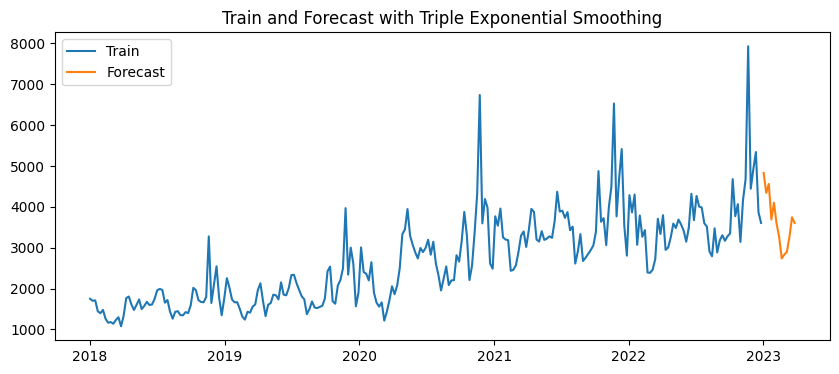

In [ ]:
# Set the size of the plot to 10 inches by 4 inches
plt.figure(figsize = (10,4))

# Plot train and forecast values
plt.plot(df.complaints, label = 'Train')
plt.plot(forecast, label = "Forecast")

# Add title and legend to the plot
plt.title("Train and Forecast with Triple Exponential Smoothing")
plt.legend()
plt.show()

In [ ]:
# Function to plot the train and forecast values
def plot_future(y, forecast, title):
  # Set the size of the plot to 10 inches by 4 inches
  plt.figure(figsize = (10,4))
  # Plot train and forecast values
  plt.plot(df.complaints, label = 'Train')
  plt.plot(forecast, label = "Forecast")
  # Add title and legend to the plot
  plt.title("Train and Forecast with Triple Exponential Smoothing")
  plt.legend()
  plt.show()

# Daily Data


In [ ]:
# Loading the bitcoin data and Setting the Index
df_daily = pd.read_csv("bitcoin_price.csv", index_col = "Date", parse_dates = True)
df_daily.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800
2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200
2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700
2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600
2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100


In [ ]:
# Display information about the DataFrame, including data types and non-null counts
df_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3392 entries, 2014-09-17 to 2023-12-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3392 non-null   float64
 1   High       3392 non-null   float64
 2   Low        3392 non-null   float64
 3   Close      3392 non-null   float64
 4   Adj Close  3392 non-null   float64
 5   Volume     3392 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 185.5 KB


In [ ]:
# Convert the DataFrame to have a daily frequency.
# This ensures that the time series is indexed by every calendar day.
df_daily = df_daily.asfreq("D")
df_daily.index

DatetimeIndex(['2014-09-17', '2014-09-18', '2014-09-19', '2014-09-20',
               '2014-09-21', '2014-09-22', '2014-09-23', '2014-09-24',
               '2014-09-25', '2014-09-26',
               ...
               '2023-12-21', '2023-12-22', '2023-12-23', '2023-12-24',
               '2023-12-25', '2023-12-26', '2023-12-27', '2023-12-28',
               '2023-12-29', '2023-12-30'],
              dtype='datetime64[ns]', name='Date', length=3392, freq='D')

In [ ]:
# Define the number of days to be used for the test set
periods = 30
# Split the data into training and test sets, taking the 4th column ('Close')
train, test = df_daily.iloc[:-periods,3], df_daily.iloc[-periods:, 3 ]
test.head()

Date
2023-12-01    38688.750000
2023-12-02    39476.332031
2023-12-03    39978.390625
2023-12-04    41980.097656
2023-12-05    44080.648438
Freq: D, Name: Close, dtype: float64

In [ ]:
# Initialize and fit a Triple Exponential Smoothing (Holt-Winters) model to the training data
# Use an additive trend component ('add'), a multiplicative seasonal component ('mul'),
# and specify the seasonal period length as 7 (daily data with weekly seasonality)

model_triple = ExponentialSmoothing(train,
                                    trend = 'mul',
                                    seasonal = "mul",
                                    seasonal_periods = 7).fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [ ]:
# Use the fitted Triple Exponential Smoothing model to forecast future values.
# The forecast is made for the same length as the 'test' data set. (30 days)
predictions_triple = model_triple.forecast(len(test))
predictions_triple

2023-12-01    37911.560426
2023-12-02    38122.396971
2023-12-03    38430.750184
2023-12-04    38608.924172
2023-12-05    38792.468561
2023-12-06    38868.699147
2023-12-07    38817.596322
2023-12-08    39014.333842
2023-12-09    39231.303211
2023-12-10    39548.625819
2023-12-11    39731.982540
2023-12-12    39920.865878
2023-12-13    39999.313863
2023-12-14    39946.724557
2023-12-15    40149.184788
2023-12-16    40372.465373
2023-12-17    40699.018277
2023-12-18    40887.708488
2023-12-19    41082.086074
2023-12-20    41162.815959
2023-12-21    41108.696931
2023-12-22    41317.046336
2023-12-23    41546.821719
2023-12-24    41882.873410
2023-12-25    42077.052252
2023-12-26    42277.083903
2023-12-27    42360.162062
2023-12-28    42304.468818
2023-12-29    42518.878701
2023-12-30    42755.337802
Freq: D, dtype: float64

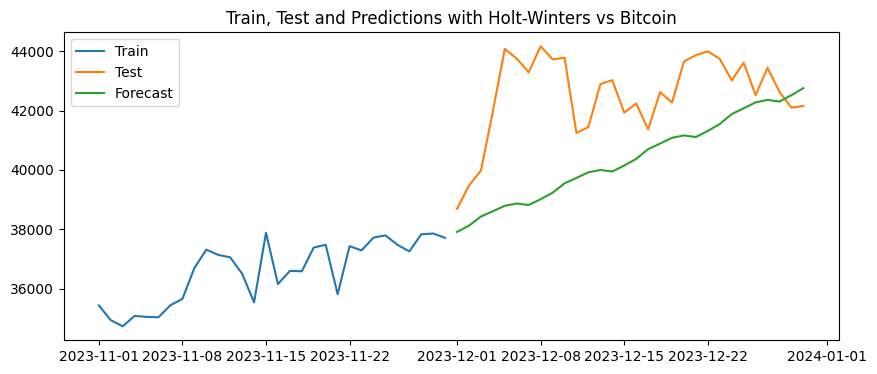

The MAE is 2242.57
The RMSE is 2695.30
The MAPE is 5.21 %


In [ ]:
# Model Assessment
# Assess the performance of the model
# using test data starting from November 2023, comparing its predictions to the actual values of Bitcoin prices.
model_assessment(train['2023-11':], test, predictions_triple, "Holt-Winters vs Bitcoin")